In [94]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/MMA/2022-1-EstMultAvanzada/Final-Project

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/MMA/2022-1-EstMultAvanzada/Final-Project


## Load Packages

In [95]:
import pandas as pd #
from datetime import datetime #
import numpy as np
import matplotlib.pyplot as plt
#from pandas import read_csv
import math
from math import sqrt #

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

# univariate data preparation
from numpy import array
from tqdm import tqdm


## Load data

In [96]:
# Load Data
df = pd.read_csv('demanda-longer.csv')

In [97]:
# Change Str to datetime type
df['Date'] = df['Date'].apply(lambda row: datetime.strptime(row, '%Y-%m-%d'))

In [98]:
# Original Time Series format
df[['Date', 'Value']]

,Date,Value
0,2016-01-01,1.432103e+08
1,2016-01-02,1.544231e+08
2,2016-01-03,1.528517e+08
3,2016-01-04,1.755391e+08
4,2016-01-05,1.817631e+08
...,...,...
2305,2022-04-26,2.157302e+08
2306,2022-04-27,2.175944e+08
2307,2022-04-28,2.142974e+08
2308,2022-04-29,2.151851e+08


Text(0.5, 1.0, 'Daily Demand')

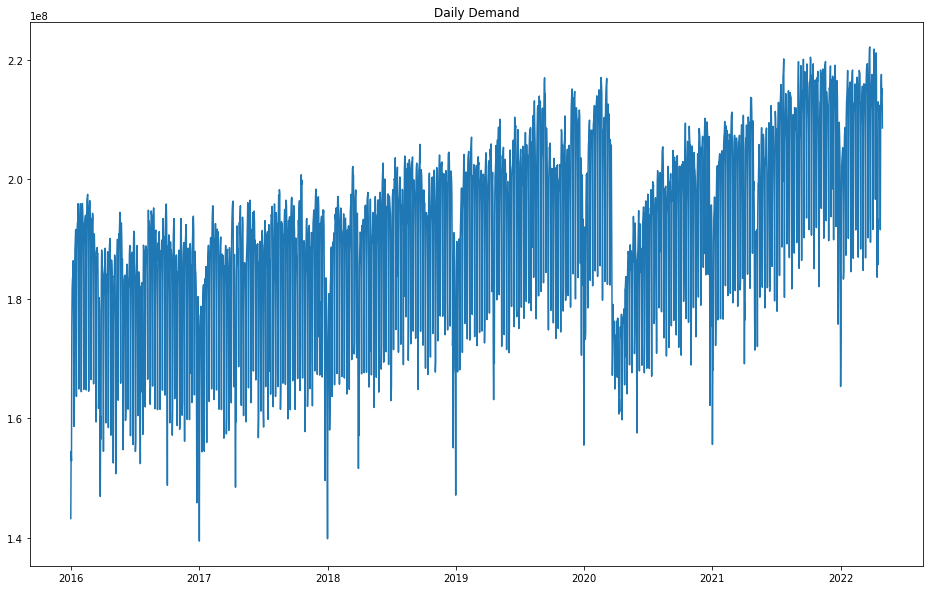

In [99]:
# Plot Demand (With COVID)
figsize_x = 16; figsize_y = 10
fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
ax.plot(df['Date'], df['Value']);
plt.title('Daily Demand')

### Play with non-Covid data

In [100]:
covid = True

In [101]:
time_lim_inf = pd.Timestamp('2016-01-01')
time_lim_sup = pd.Timestamp('2020-01-01')

In [102]:
if covid:
  df = df.loc[df['Date'] >= time_lim_inf].loc[df['Date'] <= time_lim_sup]

In [103]:
df[['Date', 'Value']]

,Date,Value
0,2016-01-01,1.432103e+08
1,2016-01-02,1.544231e+08
2,2016-01-03,1.528517e+08
3,2016-01-04,1.755391e+08
4,2016-01-05,1.817631e+08
...,...,...
1456,2019-12-28,1.953934e+08
1457,2019-12-29,1.823369e+08
1458,2019-12-30,1.933518e+08
1459,2019-12-31,1.778128e+08


## Data preparation

In [104]:
# Get time series
df_ = pd.DataFrame(df[['Value']])
dataset = df_.values

In [105]:
# [Will be used below] Normalize values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [106]:
# Split (ordered) Train and Test data
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

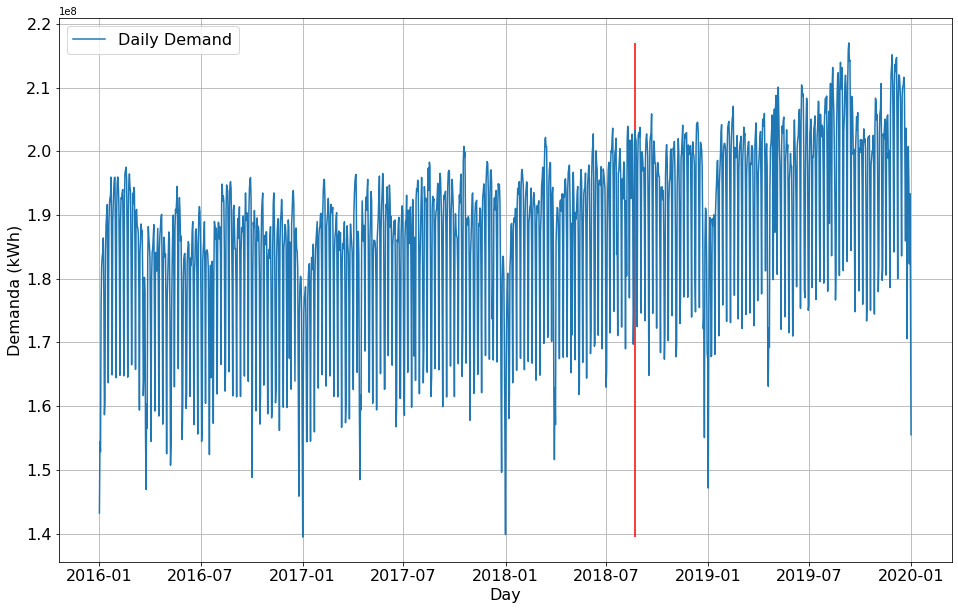

In [107]:
# Plot Demand (Pre-COVID data)
figsize_x = 16; figsize_y = 10
fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
ax.plot(df['Date'], df['Value']);
ax.vlines(df.iloc[train_size]['Date'], df['Value'].min(), df['Value'].max(), color='r')

plt.ylabel('Demanda (kWh)', fontsize=16)
plt.legend(labels=['Daily Demand'], fontsize=16)
plt.xlabel('Day', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid()

plt.savefig("demand-timeseries.png")
plt.show()

In [108]:
## Function: Converts time series data to data ready for Supervised Learning
def to_sequences(dataset, seq_size=1):
    """
    dataset: time series form
    seq_size: number of time steps to look back 
    """
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [109]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [110]:
seq_size = 1  ; n_features = 1
# What time steps to look back?
# Seq_size = 1 <-- One-step forecasting
# Nota: Larger sequences (look further back) may improve forecasting.

In [111]:
to_seq=True
# Train and Test supervised data
if to_seq:
  trainX, trainY = to_sequences(train, seq_size)
  testX, testY = to_sequences(test, seq_size)
else:
  trainX, trainY = split_sequence(train, seq_size)
  testX, testY = split_sequence(test, seq_size) 

## First attempt: Model development



In [112]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))


Shape of training set: (962, 1, 1)
Shape of test set: (495, 1, 1)


In [113]:
# Choose a model to develop
model_configs = ['vanilla', 'single', 'stacked', 'general']
model_choice = model_configs[2]
print(model_choice)

stacked


In [114]:
if model_choice == 'general':
   print('')
  # model = Sequential()
	# model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	# model.add(Dense(1))
	# model.compile(loss='mean_squared_error', optimizer='adam')
  # model.summary()
  # print('Structure ready!')
elif model_choice == 'vanilla':
  print('Vanilla LSTM (one-step univariate)')
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(seq_size, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  print('Structure ready!')
elif model_choice == 'single':
  print('Single LSTM')
  model = Sequential()
  model.add(LSTM(64, input_shape=(None, seq_size)))
  model.add(Dense(32))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.summary()
  print('Structure ready!')
elif model_choice == 'stacked':
  print('Stacked LSTM')
  model = Sequential()
  model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(32))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  print('Structure ready!')

Stacked LSTM
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 50)          10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 32)                1632      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 32,265
Trainable params: 32,265
Non-trainable params: 0
_________________________________________________________________
Structure ready!


In [115]:
# Hyperparameters
n_epochs = 100
n_batches = 1
n_neurons = 1

In [116]:
# Training fit
tqdm(model.fit(trainX, trainY, validation_data=(testX, testY), verbose=2, epochs=n_epochs))

Epoch 1/100
31/31 - 3s - loss: 0.2245 - val_loss: 0.1945 - 3s/epoch - 95ms/step
Epoch 2/100
31/31 - 0s - loss: 0.0395 - val_loss: 0.0280 - 188ms/epoch - 6ms/step
Epoch 3/100
31/31 - 0s - loss: 0.0223 - val_loss: 0.0407 - 192ms/epoch - 6ms/step
Epoch 4/100
31/31 - 0s - loss: 0.0219 - val_loss: 0.0365 - 130ms/epoch - 4ms/step
Epoch 5/100
31/31 - 0s - loss: 0.0216 - val_loss: 0.0420 - 154ms/epoch - 5ms/step
Epoch 6/100
31/31 - 0s - loss: 0.0215 - val_loss: 0.0366 - 137ms/epoch - 4ms/step
Epoch 7/100
31/31 - 0s - loss: 0.0212 - val_loss: 0.0298 - 130ms/epoch - 4ms/step
Epoch 8/100
31/31 - 0s - loss: 0.0208 - val_loss: 0.0299 - 175ms/epoch - 6ms/step
Epoch 9/100
31/31 - 0s - loss: 0.0206 - val_loss: 0.0279 - 140ms/epoch - 5ms/step
Epoch 10/100
31/31 - 0s - loss: 0.0203 - val_loss: 0.0295 - 228ms/epoch - 7ms/step
Epoch 11/100
31/31 - 0s - loss: 0.0200 - val_loss: 0.0277 - 377ms/epoch - 12ms/step
Epoch 12/100
31/31 - 0s - loss: 0.0199 - val_loss: 0.0247 - 321ms/epoch - 10ms/step
Epoch 13/100





0it [00:00, ?it/s]

In [117]:
# Forecast train and test
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [118]:
# Unscale the predictions
trainPredict_ = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform([trainY])
testPredict_ = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform([testY])

In [119]:
# Calculate Training and Testing Erroyhatrs:
rmse_train = sqrt(mean_squared_error(trainY_[0], trainPredict_[:,0]))
mape_train = mean_absolute_percentage_error(trainY_[0], trainPredict_[:,0])
mae_train = mean_absolute_error(trainY_[0], trainPredict_[:,0])

rmse_test = sqrt(mean_squared_error(testY_[0], testPredict_[:,0]))
mape_test = mean_absolute_percentage_error(testY_[0], testPredict_[:,0])
mae_test = mean_absolute_error(testY_[0], testPredict_[:,0])


## Plot predictions + Show results

Model: stacked


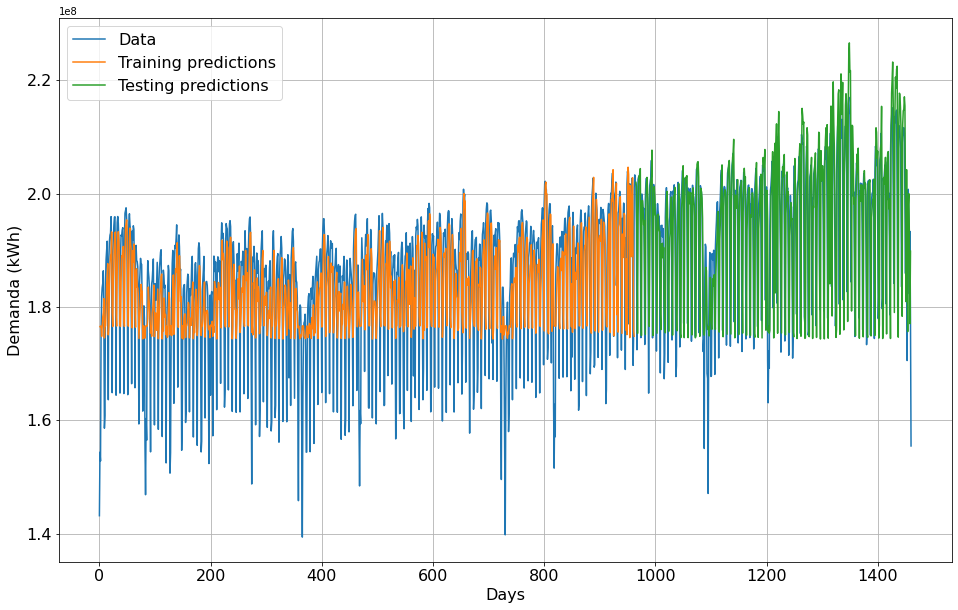

Configuration: 	
model choice: 	 stacked
epochs: 	 100
batches: 	 1
neurons: 	 1
---
Errors: 
Train RMSE: 	 9846612.659, MAPE: 0.046  MAE: 8118186.867 
Test RMSE: 	 12523818.960, MAPE: 0.048  MAE: 9215962.061 


In [120]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict_)+seq_size, :] = trainPredict_

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_)+(seq_size*2)+1:len(dataset)-1, :] = testPredict_

# Plot Demand
figsize_x = 16; figsize_y = 10
fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
ax.plot(scaler.inverse_transform(dataset))
ax.plot(trainPredictPlot)
ax.plot(testPredictPlot)
#plt.title('Model: {}'.format(model_choice), fontsize=20)
plt.legend(labels=['Data', 'Training predictions', 'Testing predictions'], fontsize=16)
plt.xlabel('Day', fontsize=16)
plt.ylabel('Demanda (kWh)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
print('Model: {}'.format(model_choice))
plt.grid()
plt.show()

# Print
print('Configuration: \t')
print('model choice: \t', model_choice)
print('epochs: \t', n_epochs)
print('batches: \t', n_batches)
print('neurons: \t', n_neurons)
print('---')
print('Errors: ')
print('Train RMSE: \t %.3f, MAPE: %.3f  MAE: %.3f ' % (rmse_train, mape_train, mae_train))
print('Test RMSE: \t %.3f, MAPE: %.3f  MAE: %.3f ' % (rmse_test, mape_test, mae_test))

## Full Model Development

## Auxiliary Functions

In [121]:
# Data Transformation: 
# Convert Time Series structure to Supervised Learning structure
"""
The data must be in Input (X) and Output (Y) for a Supervised Learning model
"""
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [122]:
# Data transformation: 
# Calculate the differenced series 
"""
Differencing can help stabilise the mean of a time series by 
removing changes in the level of a time series, and 
therefore eliminating (or reducing) trend and seasonality.
"""
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)


The Network configuration we will use is a simple one:

```
  # model = Sequential()
	# model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	# model.add(Dense(1))
	# model.compile(loss='mean_squared_error', optimizer='adam')
  # model.summary()
```



In [123]:
# Data transformation:
# Normalize the data to a scale of (0, 1)
"""
Note: The scaling for your outputs is important in defining the activation 
function for the output layer. The choice of output activation is important, 
and knowledge of how your outputs are scaled is important in determining 
which activation to use.
"""
def scale(train, test):
	# Fit scaler only using training data to not get input about testing data
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# Transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# Transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


In [124]:
 # Inverse Data Transform
 # Recuperate original values after Scaling
 """
 We will need this in order to get interpretable errors and recuperate forecasts.
 """
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]


In [125]:
# Evaluate model on dataset and return Errors
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
	# separate
	X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
	# reshape
	reshaped = X.reshape(len(X), 1, 1)
	# forecast dataset
	output = model.predict(reshaped, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, X[i], yhat)
		# invert differencing
		yhat = yhat + raw_data[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
	mape = mean_absolute_percentage_error(raw_data[1:], predictions)
	mae = mean_absolute_error(raw_data[1:], predictions)

	return rmse, mape, mae
 

In [126]:
# Evaluate model on dataset and return Predicted values and Original values
def evaluate_2(model, raw_data, scaled_dataset, scaler, offset, batch_size):
	# separate
	X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
	# reshape
	reshaped = X.reshape(len(X), 1, 1)
	# forecast dataset
	output = model.predict(reshaped, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, X[i], yhat)
		# invert differencing
		yhat = yhat + raw_data[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
	mape = mean_absolute_percentage_error(raw_data[1:], predictions)
	mae = mean_absolute_error(raw_data[1:], predictions)

	return predictions, raw_data[1:]
 

In [127]:
# Fit the LSTM model, Evaluate train and test, Save Errors, Save Model
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons, model_=None):
	
	# Get input and output
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	
	# Construct model
	if model_:
		model = model_
	else:
		model = Sequential()
		model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
		model.add(Dense(1))
		model.compile(loss='mean_squared_error', optimizer='adam')
	
	# Fit model
	train_rmse, test_rmse, train_mape, test_mape, train_mae, test_mae = list(), list(), list(), list(), list(), list()
 
	
	for i in range(nb_epoch):

		# For each run-through, fit the model
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	
		# Evaluate model on train data and save errors
		raw_train = raw[-(len(train)+len(test)+1):-len(test)]
		a, b, c = evaluate(model, raw_train, train, scaler, 0, batch_size)
		train_rmse.append(a)
		train_mape.append(b)
		train_mae.append(c)
		model.reset_states()
		# Evaluate model on test data and save errors
		raw_test = raw[-(len(test)+1):]
		d, e, f = evaluate(model, raw_test, test, scaler, 0, batch_size)
		test_rmse.append(d)
		test_mape.append(e)
		test_mae.append(f)
		model.reset_states()
	
	history = pd.DataFrame()
	history['train_rmse'], history['test_rmse'] = train_rmse, test_rmse
	history['train_mape'], history['test_mape'] = train_mape, test_mape
	history['train_mae'], history['test_mae'] = train_mae, test_mae
	return history, model
 

## Models

In [128]:
bool(None)

False

In [129]:
# Load time Series
series = pd.DataFrame(df[['Value']])

# Data Transform: Differences
raw_values = series.values
diff_values = difference(raw_values, 1)

# Data Transform: Supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# Split: 2/3 Train 1/3 Test
split_num = int(np.round(len(supervised) * 0.66))
train, test = supervised_values[0:split_num], supervised_values[split_num:]

# Data Transform: Scale
scaler, train_scaled, test_scaled = scale(train, test)

# Prep for evaluate Function
train_trimmed = train_scaled[2:, :]

# Hyperparameters
n_batch = 1					
n_neurons = 1
epochs_list = [40, 40, 40, 40, 40]		# Run 5 models

# Save
results = pd.DataFrame()

if True:
	models    = [None for i in range(len(epochs_list))]
	histories = [None for i in range(len(epochs_list))]

# Fit Models!
for i, n_epochs in tqdm(enumerate(epochs_list)):
	if models[i]:
		history, model = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
	else:
		history, model = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons, model_=models[i])
	
	# Save Models and their errors
	models[i] = model
	histories[i] = history






0it [00:00, ?it/s]



1it [02:35, 155.31s/it]



2it [05:02, 150.75s/it]



3it [07:42, 154.90s/it]



4it [10:20, 155.85s/it]



5it [12:57, 155.43s/it]






  0%|          | 0/5 [00:00<?, ?it/s]



100%|██████████| 5/5 [00:00<00:00, 30.84it/s]


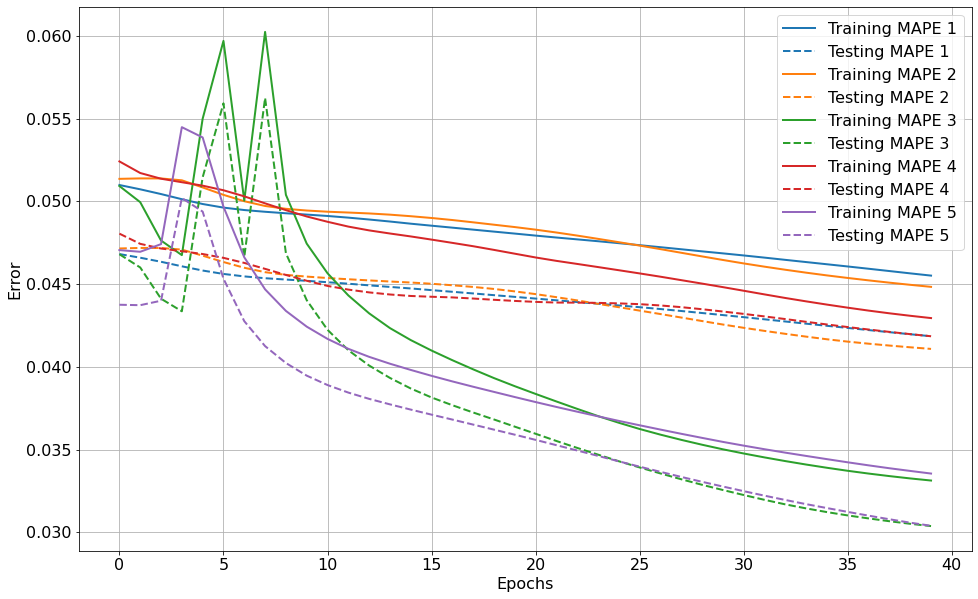

In [168]:
# Plot 1
figsize_x = 16; figsize_y = 10
fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))

for i in tqdm(range(len(epochs_list))):

	ax.plot(histories[i]['train_mape'], linestyle='-', color='C{}'.format(i), lw=2, label='Training MAPE {}'.format(i + 1))
	ax.plot(histories[i]['test_mape'], linestyle='--', color='C{}'.format(i), lw=2, label='Testing MAPE {}'.format(i + 1))

	plt.legend(fontsize=16)

	plt.xlabel('Epochs', fontsize=16)
	plt.ylabel('Error', fontsize=16)
	plt.xticks(fontsize=16)
	plt.yticks(fontsize=16)
	plt.grid()
plt.savefig('error-epochs.png')
plt.show()

In [157]:
df['Value'].mean()

187698631.4725667

In [145]:
len(histories)

5

In [161]:
m1 = histories[0][-1::]
m2 = histories[1][-1::]
m3 = histories[2][-1::]
m4 = histories[3][-1::]
m5 = histories[4][-1::]

In [164]:
frames = [m1, m2, m3, m4, m5]

errors_model = pd.concat(frames)

In [166]:
errors_model

,train_rmse,test_rmse,train_mape,test_mape,train_mae,test_mae
39,1.091118e+07,1.068992e+07,0.045514,0.041851,8.091353e+06,7.975352e+06
39,1.089478e+07,1.065995e+07,0.044835,0.041086,7.959680e+06,7.819050e+06
39,8.442259e+06,8.189297e+06,0.033133,0.030380,5.890012e+06,5.815191e+06
39,1.016502e+07,1.039948e+07,0.042948,0.041851,7.628404e+06,7.981676e+06
39,8.555226e+06,8.399531e+06,0.033555,0.030398,5.961890e+06,5.823692e+06


## Evaluate each model

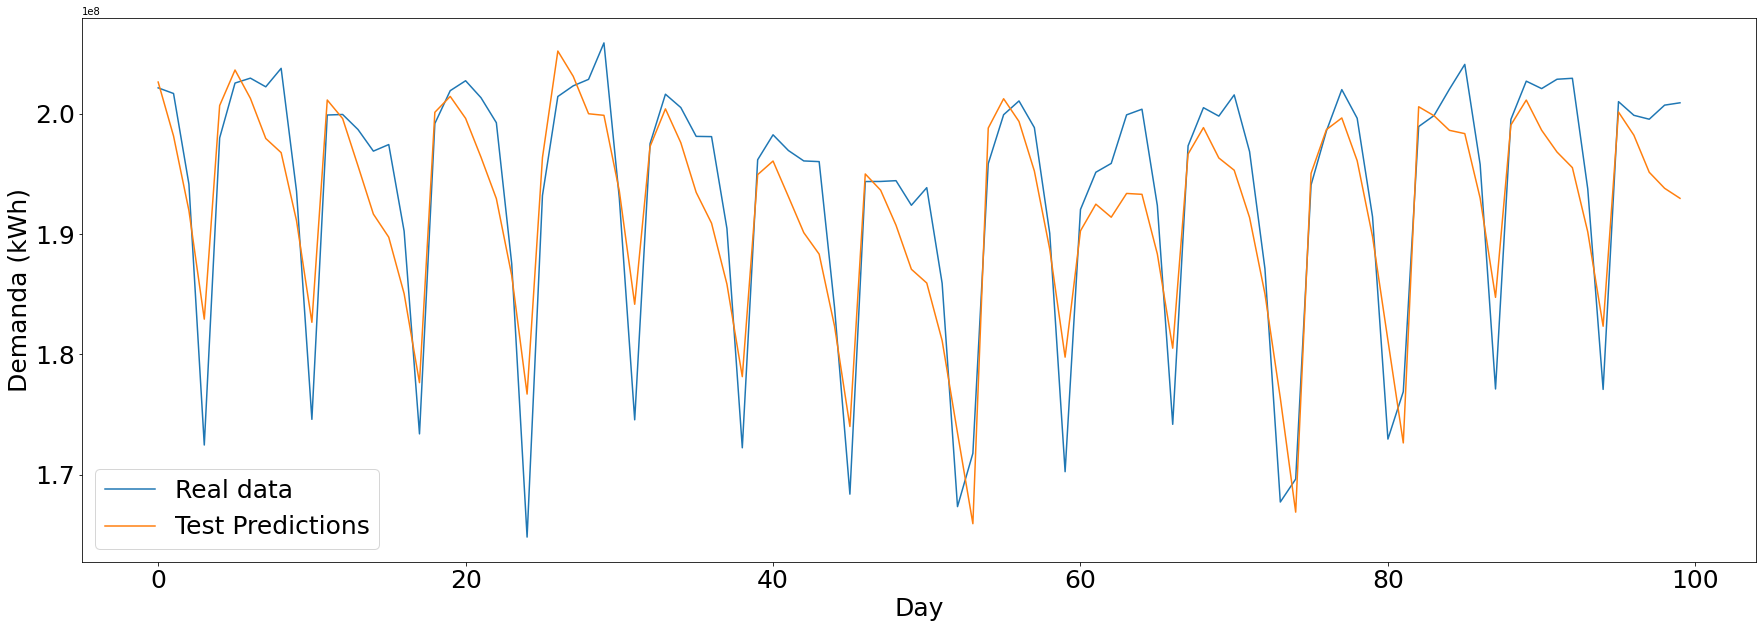

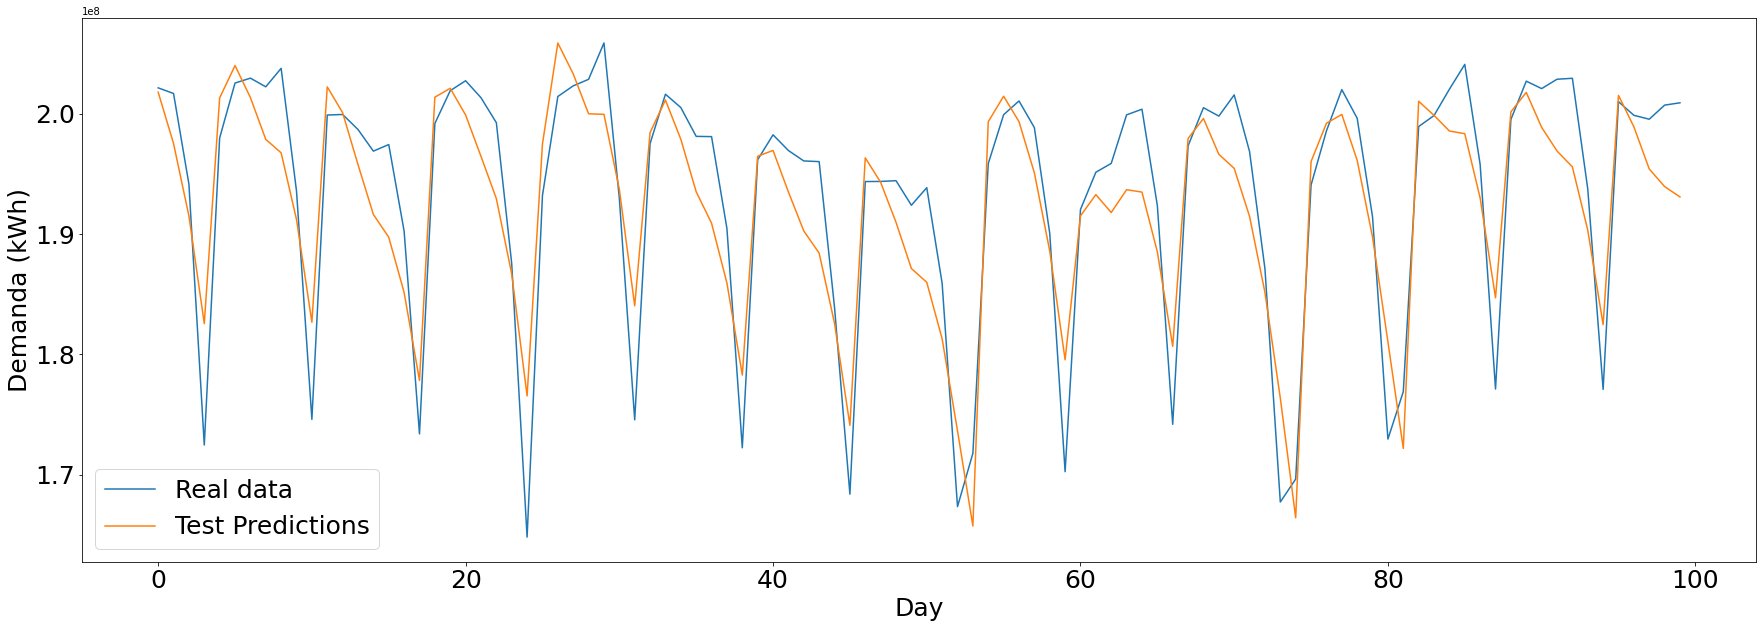

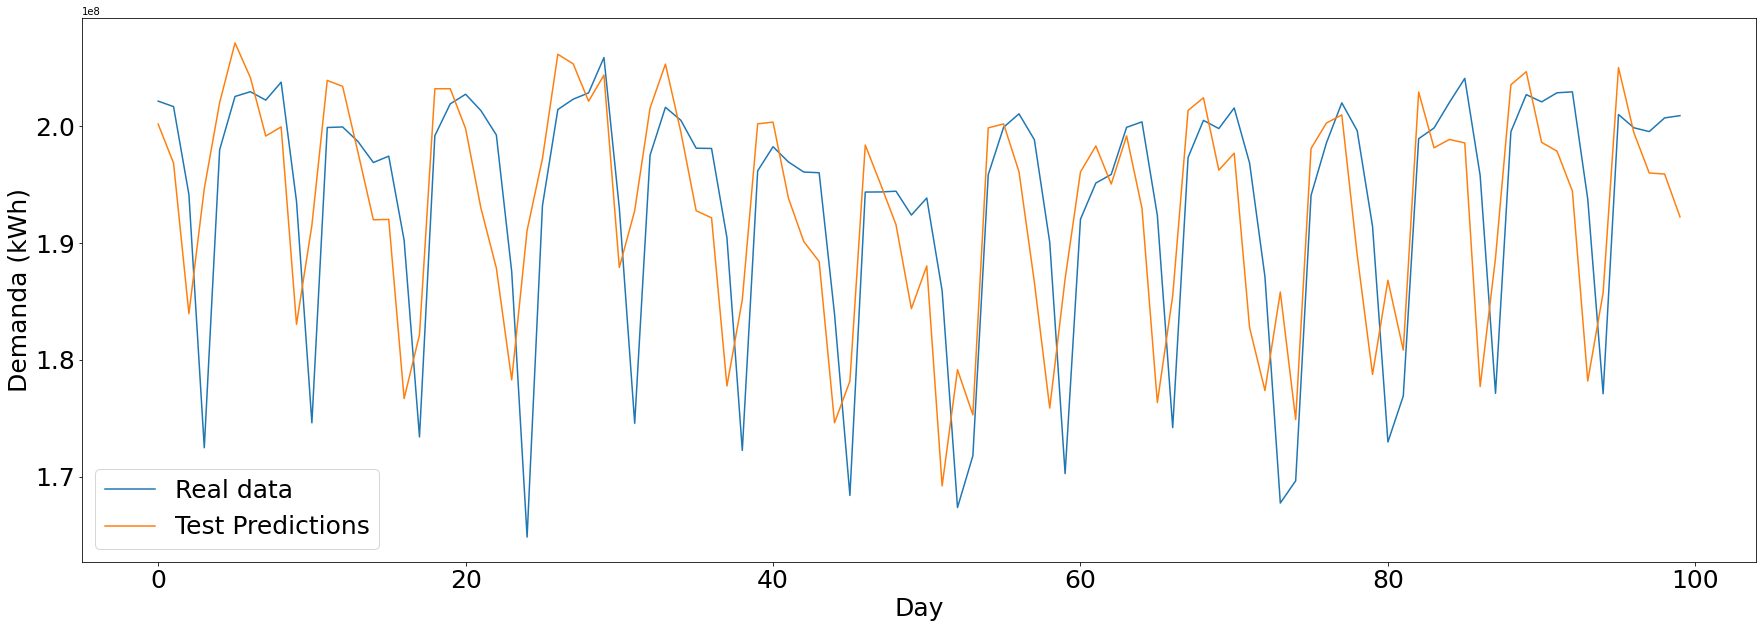

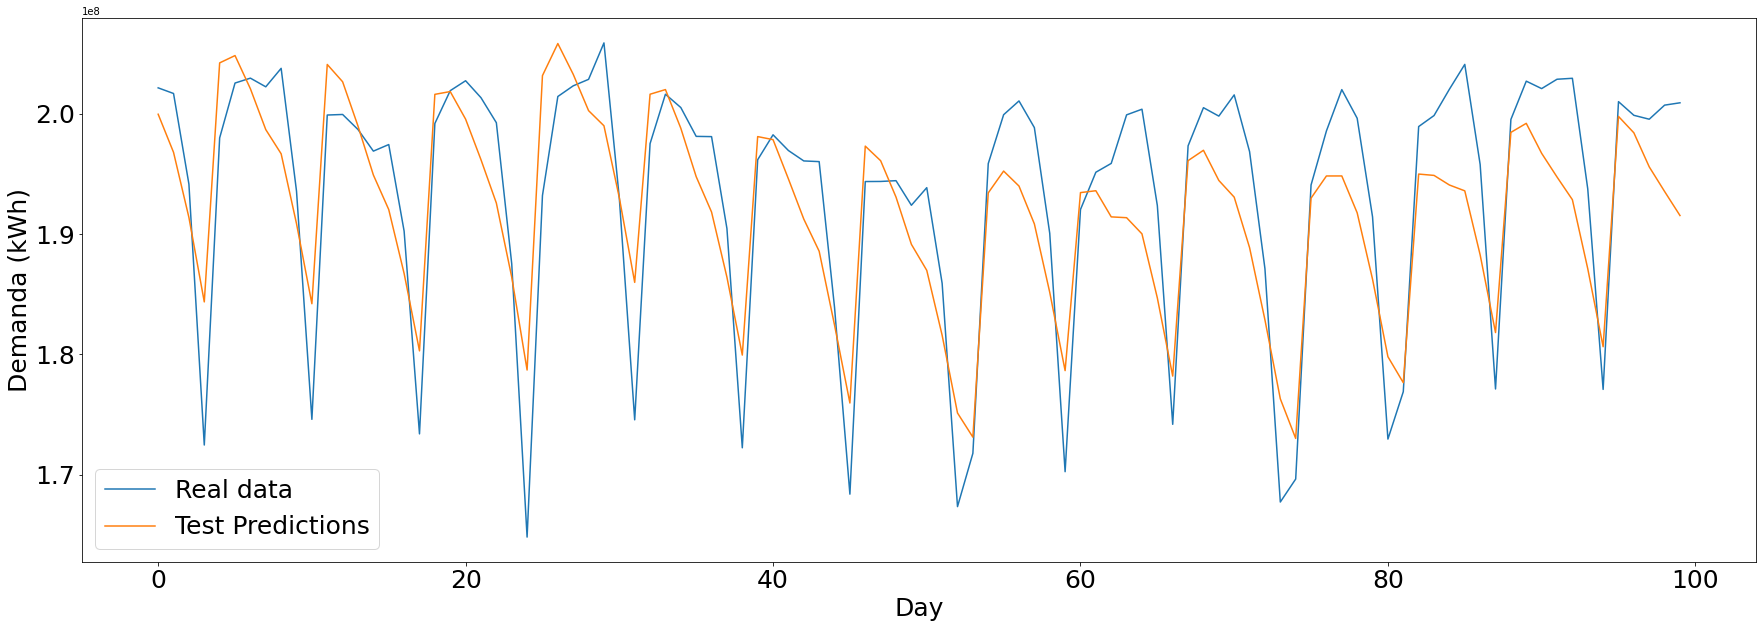

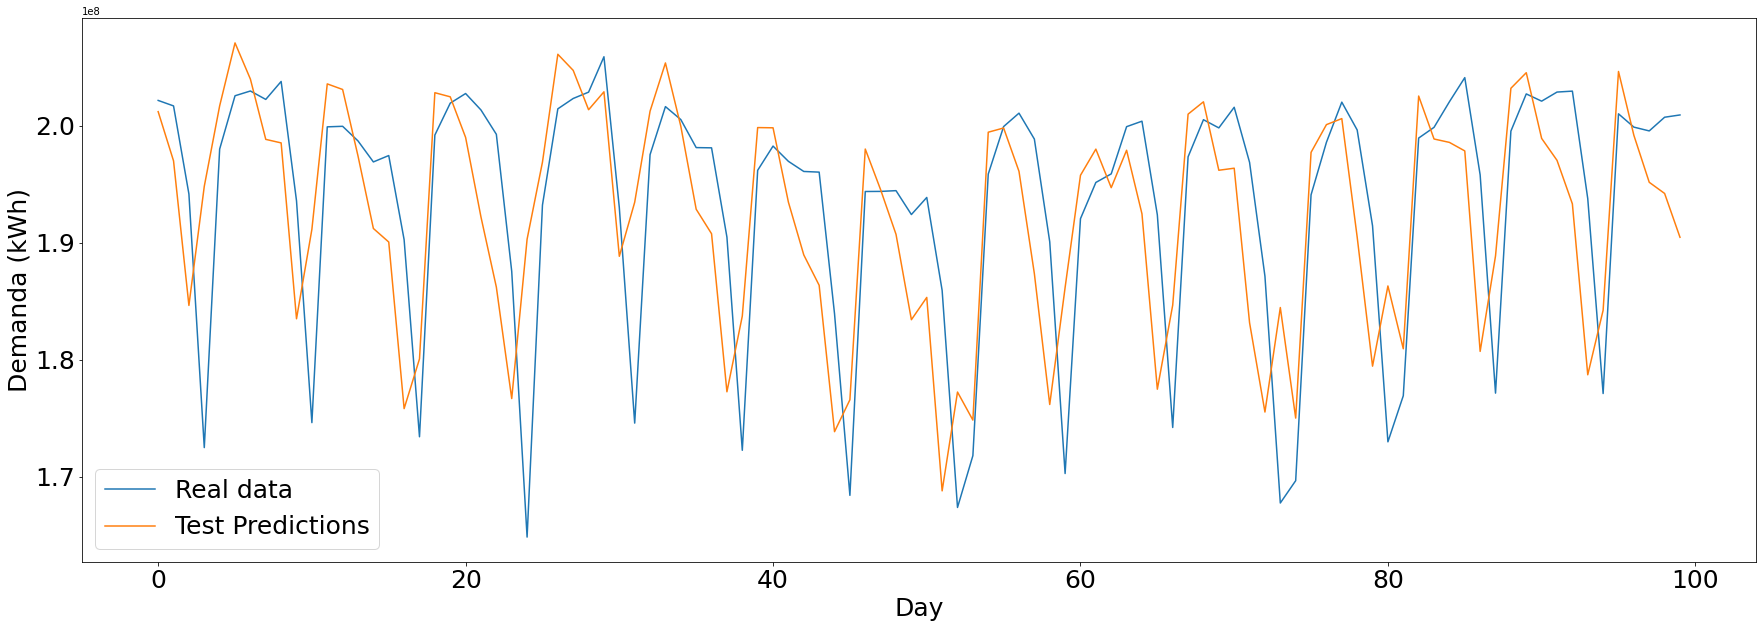

In [176]:
# load dataset
series = pd.DataFrame(df[['Value']])
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
# split data into train and test-sets
split_num = int(np.round(len(supervised) * 0.66))
train, test = supervised_values[0:split_num], supervised_values[split_num:]
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
# fit and evaluate model
train_trimmed = train_scaled[2:, :]

# parameters
train=train_trimmed
test=test_scaled
raw=raw_values
batch_size=1

for model in models:

  # evaluate model on train data
  raw_train = raw[-(len(train)+len(test)+1):-len(test)]
  pred_train, rawww_train = evaluate_2(model, raw_train, train, scaler, 0, batch_size)


  # evaluate model on test data
  raw_test = raw[-(len(test)+1):]
  pred_test, rawww_test = evaluate_2(model, raw_test, test, scaler, 0, batch_size)

  fig,ax = plt.subplots(figsize=(30, figsize_y))
  data = [raw_train, pred_train]
  data = [raw_test, pred_test]
  for i, d in enumerate(data):
    ax.plot(d[:100], 'C{}'.format(i));
    plt.xlabel('Day', fontsize=25)
    plt.ylabel('Demanda (kWh)', fontsize=25)
    plt.legend(['Real data', 'Test Predictions'], fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.title('M3 ')
    plt.grid()
    plt.savefig('model-{}.png'.format(i))
  plt.show()

In [170]:
len(data[0])

497

In [171]:
len(train), len(test)

(962, 496)

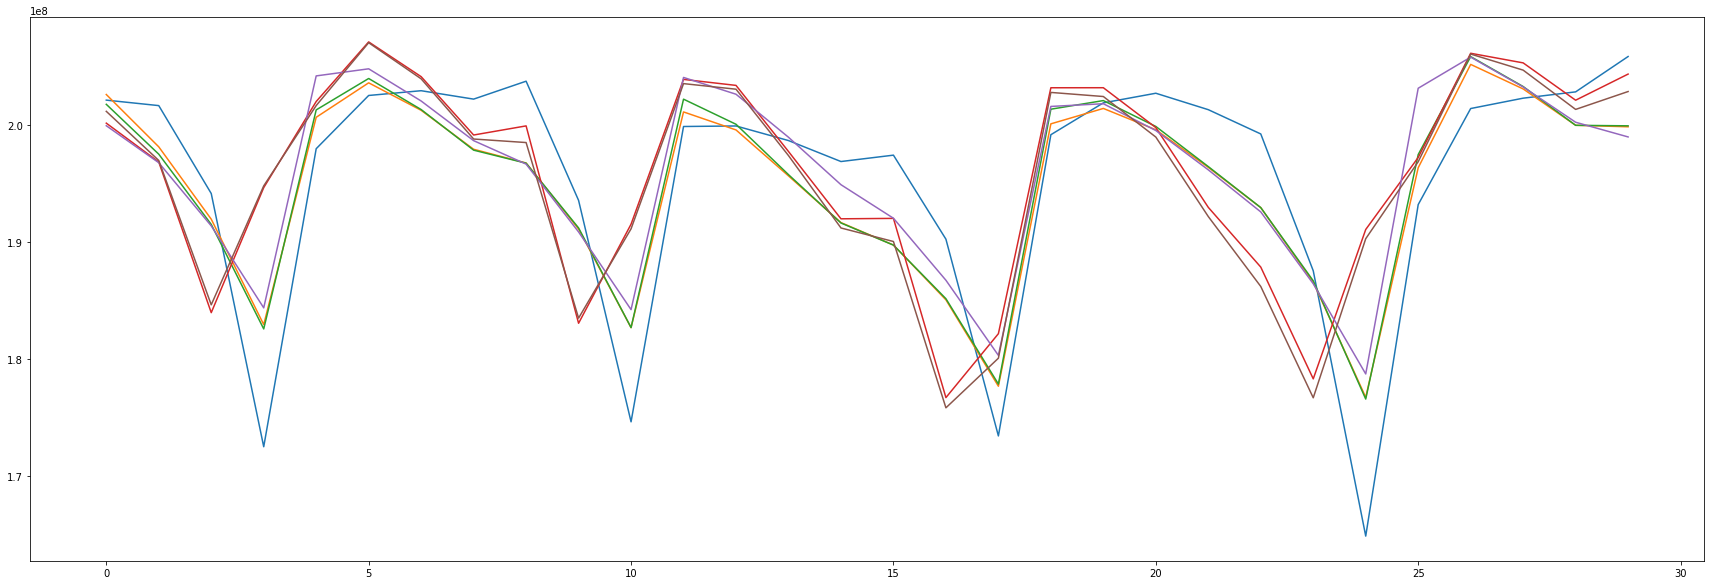

In [172]:
# load dataset
series = pd.DataFrame(df[['Value']])
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
# split data into train and test-sets
split_num = int(np.round(len(supervised) * 0.66))
train, test = supervised_values[0:split_num], supervised_values[split_num:]
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
# fit and evaluate model
train_trimmed = train_scaled[2:, :]

# parameters
train=train_trimmed
test=test_scaled
raw=raw_values
batch_size=1

fig,ax = plt.subplots(figsize=(30, figsize_y))
data = [raw_test]

for j, model in enumerate(models):

  # evaluate model on train data
  raw_train = raw[-(len(train)+len(test)+1):-len(test)]
  pred_train, rawww_train = evaluate_2(model, raw_train, train, scaler, 0, batch_size)


  # evaluate model on test data
  raw_test = raw[-(len(test)+1):]
  pred_test, rawww_test = evaluate_2(model, raw_test, test, scaler, 0, batch_size)

  data += [pred_test]

for i, d in enumerate(data):
  ax.plot(d[:30], 'C{}'.format(i));